In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-07 09:12:52--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-07 09:12:52 (30.1 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [3]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [6]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
# Make supervised dataset
# Difference makes first value = 0
# hence [1:] is added

series = df['DiffLogPassengers'].to_numpy()[1:]

T = 10 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [10]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [11]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453121

In [12]:
lr.score(Xtest, Ytest)

0.6492870172668166

In [13]:
# Boolean index

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # First T+1 values are not predictable

In [14]:
# Need to compute un-differenced predictions

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [15]:
# Last known train value

last_train = train.iloc[-1]['LogPassengers']

In [16]:
# 1-step forecast

# 1-step forecast

df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

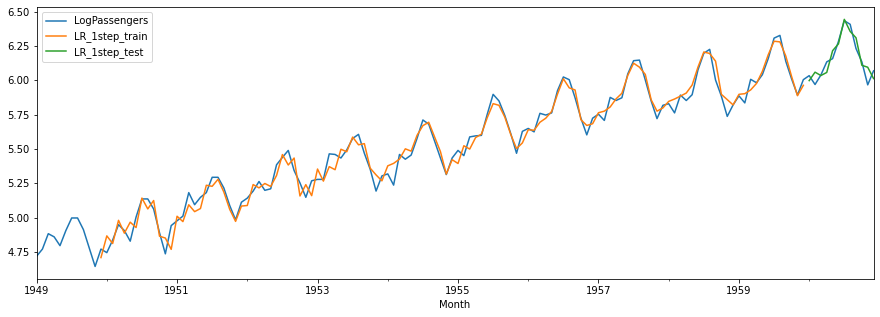

In [17]:
# Plot 1-step forecast

df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-step

In [18]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = lr.predict(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [20]:
# Save multi-step forecast to the dataframe

df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

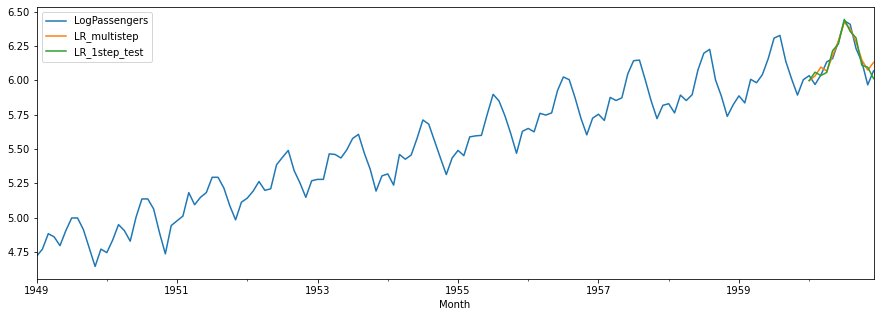

In [21]:
# Plot 1-step and multistep

df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-output

In [22]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [23]:
# Split into train and test
# 

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [24]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8141637147930583

In [25]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.7690077978619654

In [28]:
# Save output to dataframe

df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())

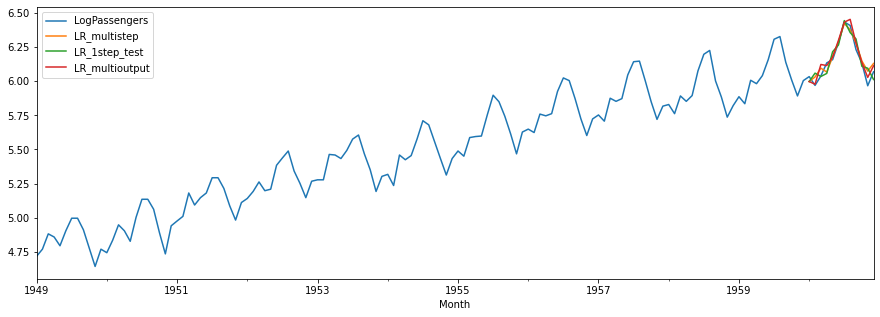

In [29]:
df[['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']].plot(figsize = (15, 5));

In [30]:
# Use different metric

# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multistep'])
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.007109281288502525
Multi-output MAPE: 0.005245261617574867


### Test Other Models

In [35]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step Forecast:", name)

  # Store 1-step forecast

  df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(Xtest)

  # Generate multi-step forecast

  multistep_predictions = []

  # First test input

  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # Update the predictions list

    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Store multi-step forecast

  df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast

  mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print('Test MAPE (multi-step):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogPassengers', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']].plot(figsize = (15, 5));

One-step Forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


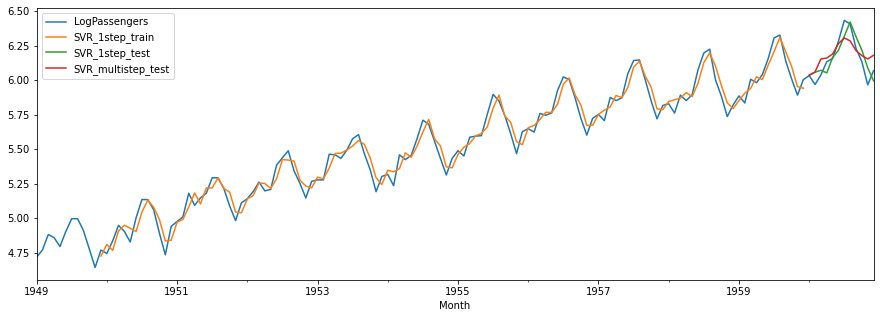

In [36]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step Forecast: RF
Test MAPE (multi-step): 0.0051042318091428325


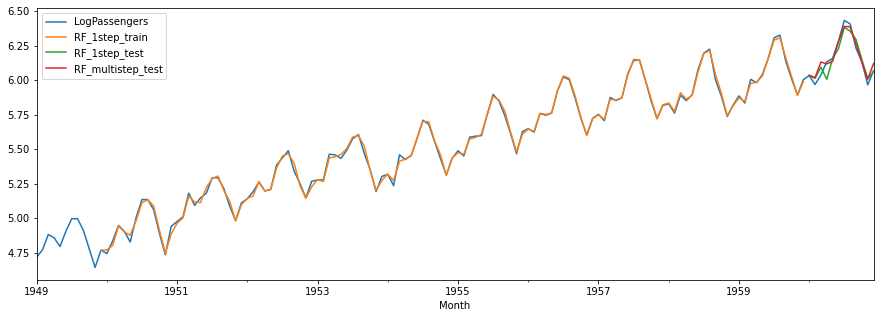

In [37]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

### Multi-output

In [38]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # Store multioutput forecast to dataframe

  df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(Xtest_m).flatten())

  # MAPE of multioutput forecast

  mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
  print('Test MAPE (multioutput):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogPassengers', f'{name}_1step_train',
      f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']].plot(figsize = (15, 5));

In [43]:
# Create SVR

class SVRWrapper:
  def __init__(self, h, **args): # h = forecast horizon
    self.h = h # forecast horizon saved
    self.models = [SVR(**args) for _ in range(h)] # instantiate multiple SVR objects

  def fit(self, X, Y): # call fit for each SVR for each column of target matrix
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])

  def predict(self, X): # call predict for each SVR
    P = [m.predict(X) for m in self.models]
    return np.hstack(P) # hstack is used because each output is an n-length vector

Test MAPE (multioutput): 0.010731361803536803


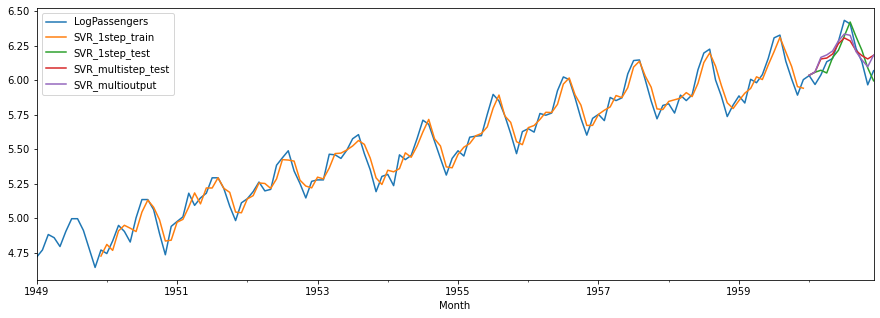

In [44]:
multi_output_forecast(SVRWrapper(Ntest), 'SVR')

Test MAPE (multioutput): 0.004720491618236227


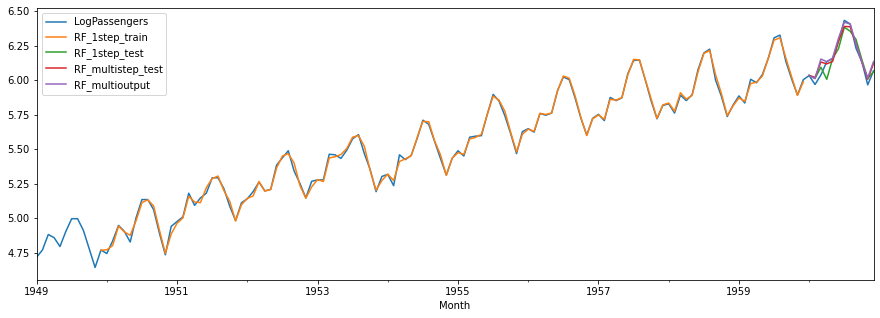

In [45]:
multi_output_forecast(RandomForestRegressor(), 'RF')